# 3. Solving Differential Equations with the Shooting Method
## B. The Radial Function

### Where we left off

We were able to solve for $S(\eta)$ of $\psi(\xi, \eta, \phi)=R(\xi)S(\eta)\Phi(\phi)$ for various values of $c^2$. In the process, we were also able to express $\Lambda$ as a fourth-degree polynomial of $c^2$. This was a particularly important achievement as this $\Lambda$ is also present in the differential equation for the radial equation $R(\eta)$. 

$$ \frac{d }{d \xi}\left [ \left ( \xi^2 - 1 \right ) \frac{d R}{d \xi} \right ] + \left [ 2D\xi + c^2 \xi^2 -\frac{\mu^2}{\xi^2 - 1} - \Lambda\left ( c^2 \right ) \right ]R = 0$$

Just like for $S(\eta)$, the function $R(\xi)$ can be expressed with another function $g(\xi)$ in the following way.

$$R(\xi)=\left ( \xi^2 - 1 \right ) ^{\mu/2} g(\xi)$$

Substituting yields

$$\left ( \xi^2 -1 \right ) g'' + 2\left ( \mu + 1 \right ) \xi \, g' + \left [2 D \xi +c^2 \xi^2 + \mu \left ( \mu + 1 \right ) - \Lambda\left ( c^2 \right )  \right ] g = 0$$

Note that as $c^2=\frac{1}{2}ED^2$, $c^2$ is dependent on $E$. Thus, with this differential equation, we intend to find values for $E$ which results in approprite $g(\xi)$s.

### Conditions on the function $g(\xi)$

Similar to $f(\eta)$, we let $g(1)=1$ and obtain $g'(1)$ from the limiting form of the equation above when $\xi \to 1+$.

$$g'(1)=-\frac{2D + c^2 + \mu\left ( \mu + 1 \right ) - \Lambda\left ( c^2 \right )}{2 \left ( \mu + 1 \right )}$$

The constraint for $f(\eta)$ was $f(0)=0$ or $f'(0)=0$ depending on the symmetry. The constraint for $g(\xi)$ is derived from the fact that the HMI is a bound state. Recall that for atomic orbitals, as $r \to \infty$, $\psi \to 0$. Thus, for the HMI, as $\xi \to \infty$, $\psi \to 0$. An actually implementable constraint is something like $g(\xi_{\text{cutoff}})=0$ where $\xi_{\text{cutoff}} \approx 10$. For $\xi > \xi_{\text{cutoff}}$, $g(\xi)=0$, thus $R(\xi)=0$. 

### The shooting method for $g(\xi)$

For this example, $\mu = 0$, $l = 0$, and $D = 2$.

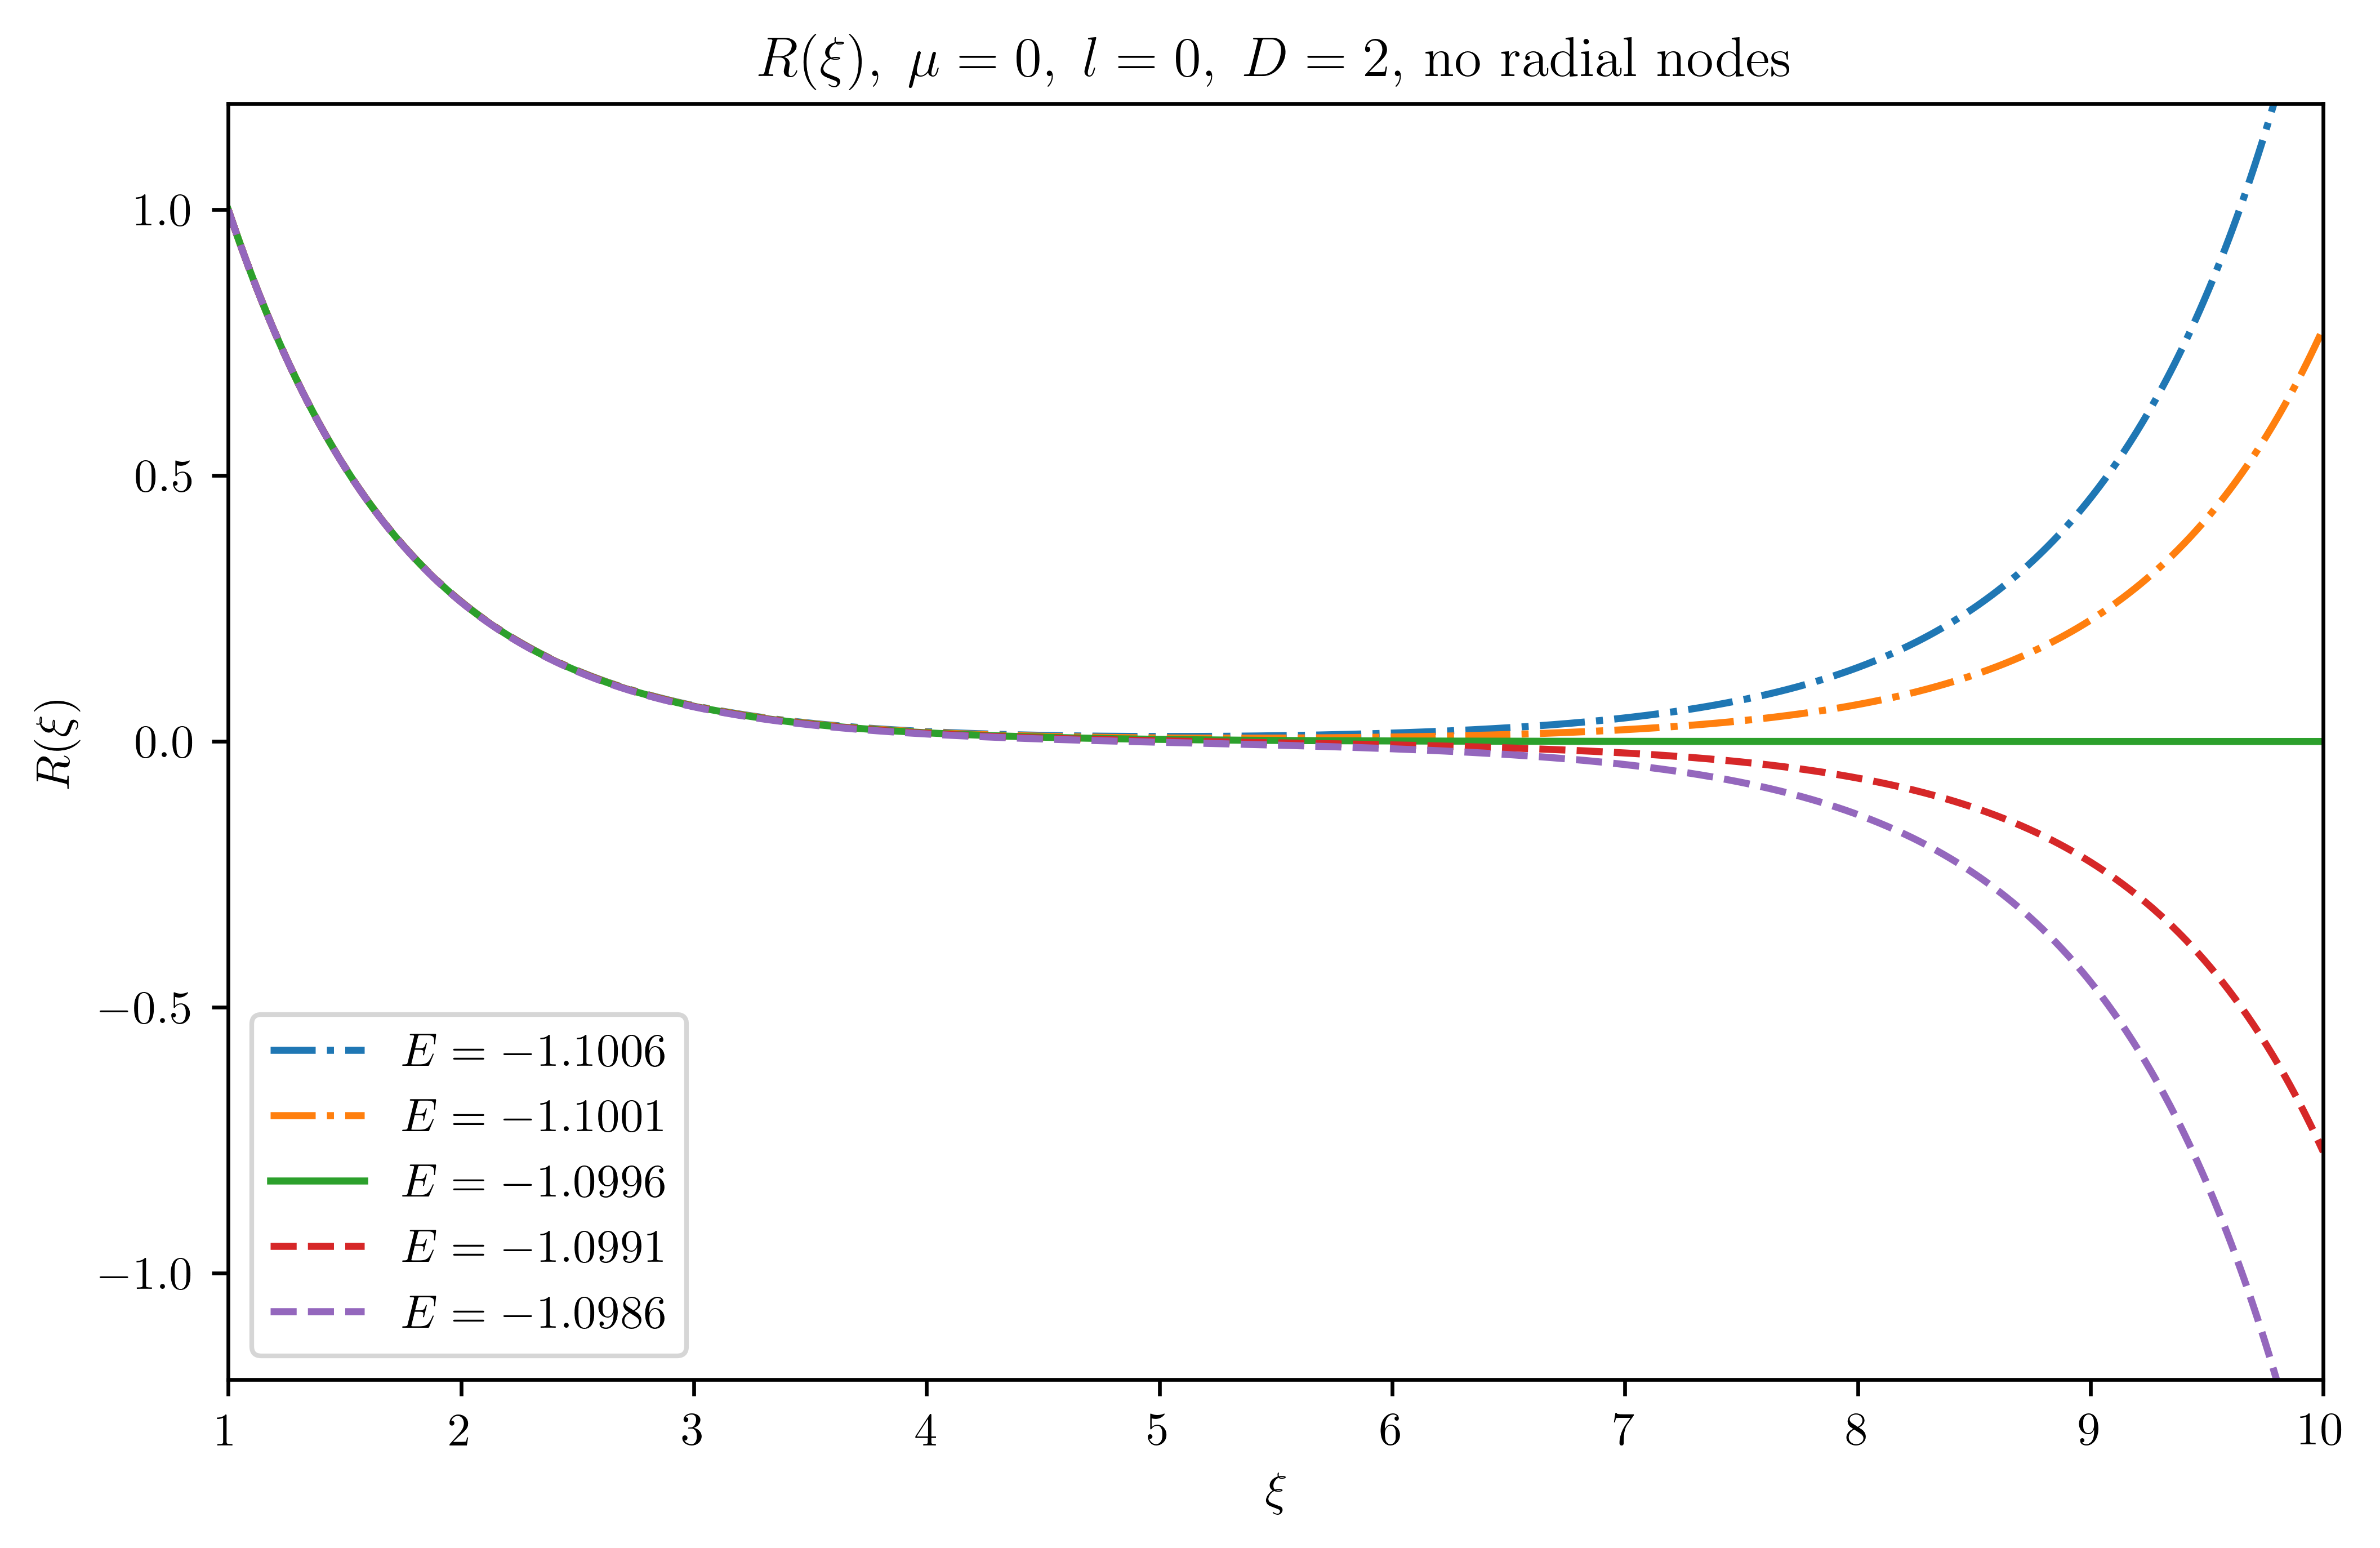

In [1]:
import numpy as np
from numpy import polynomial as P 
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "figure.figsize": [8.0, 5.0]})

try:
    # this may look good for retina display users
    %config InlineBackend.figure_format = 'retina'
except:
    pass

# lambdas we calculated before
def get_lbda(mu, l):
    # only for cases l <= 2
    # lambdas we calculated before
    import os
    filename = f"data_lbda/lbda_{mu}{l}.txt"
    filedir = os.path.join(os.path.abspath(''), filename)
    lbda_coef = None
    with open(filedir, 'r') as file:
        lbda_coef = np.loadtxt(file)
    return P.Polynomial(lbda_coef)

# mu, l, as declared above
mu = 0
l = 0
D = 2
lbda = get_lbda(mu, l)

# for a given E_val, solve R(xi)
# also used to calculate g(10) for optimization
def calculate_R(mu, l, E_val, lbda, cutoff=10, g10_instead=False):
    c2 = (1/2) * E_val * (D**2)

    # initial value of g and g'
    q1 = np.array([1,-(2*D + c2 + mu*(mu+1) - lbda(c2))/(2*(mu+1))])
    
    G = lambda xi, q: np.array([[0, 1],
    [-(2*D*xi + c2*(xi**2) + mu*(mu+1) - lbda(c2))/(xi**2 - 1),
    -(2*(mu+1)*xi)/(xi**2 - 1)]]) @ q
    
    # solve for g(xi) for 1 < xi <= 10
    # exclude xi = 1 to avoid a divide-by-zero error
    xi_span_for_calc = np.linspace(1, cutoff, cutoff*100)
    eps = 1e-10
    xi_span_for_calc[0] = 1 + eps
    
    sol = solve_ivp(G, [1 + eps, cutoff], q1, t_eval=xi_span_for_calc)
    
    # for optimization only
    if g10_instead:
        return sol.y[0][-1]
    
    # calculate R from g
    R_vals = ((xi_span_for_calc ** 2 - 1)**(mu/2)) * sol.y[0]
    
    # add back R(xi) = 0 or 1 depending on mu
    R_vals[0] = 1 if mu == 0 else 0
    
    return R_vals

# use shooting method to solve
cutoff = 10
E_val_guess = -1.1
objective = np.vectorize(lambda E: calculate_R(mu, l, E, lbda, cutoff=cutoff, g10_instead=True))
E_val_final, = fsolve(objective, E_val_guess)

# evaluate R_vals of E_val_final -0.2, 0, +0.2
E_vals = np.linspace(-0.001, 0.001, 5) + E_val_final

fig, ax = plt.subplots()

lss = ["-.", "-.", "-", "--", "--"]

xi_span = np.linspace(1, cutoff, cutoff*100)

for ind, E_val in enumerate(E_vals):
    R_vals = calculate_R(mu, l, E_val, lbda)
    E_val_label = f'$E = {E_val:.4f}$'
    ax.plot(xi_span, R_vals, label=E_val_label, ls=lss[ind])
ax.set_title(fr'$R(\xi), \; \mu = {mu}, \; l = {l}, \; D = {D}$, no radial nodes')
ax.legend()
ax.set_ylim(-1.2, 1.2)
ax.set_xlim(1, 10)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$R(\xi)$');

Note that with different initial guesses of $E$, a different $R(\xi)$ of the same $\mu, l$, and $D$ can be also be calculated. Note that for $R(\xi)$ of higher $E$, we need to use a greater $\xi_{cutoff}$ to attain accurate results.

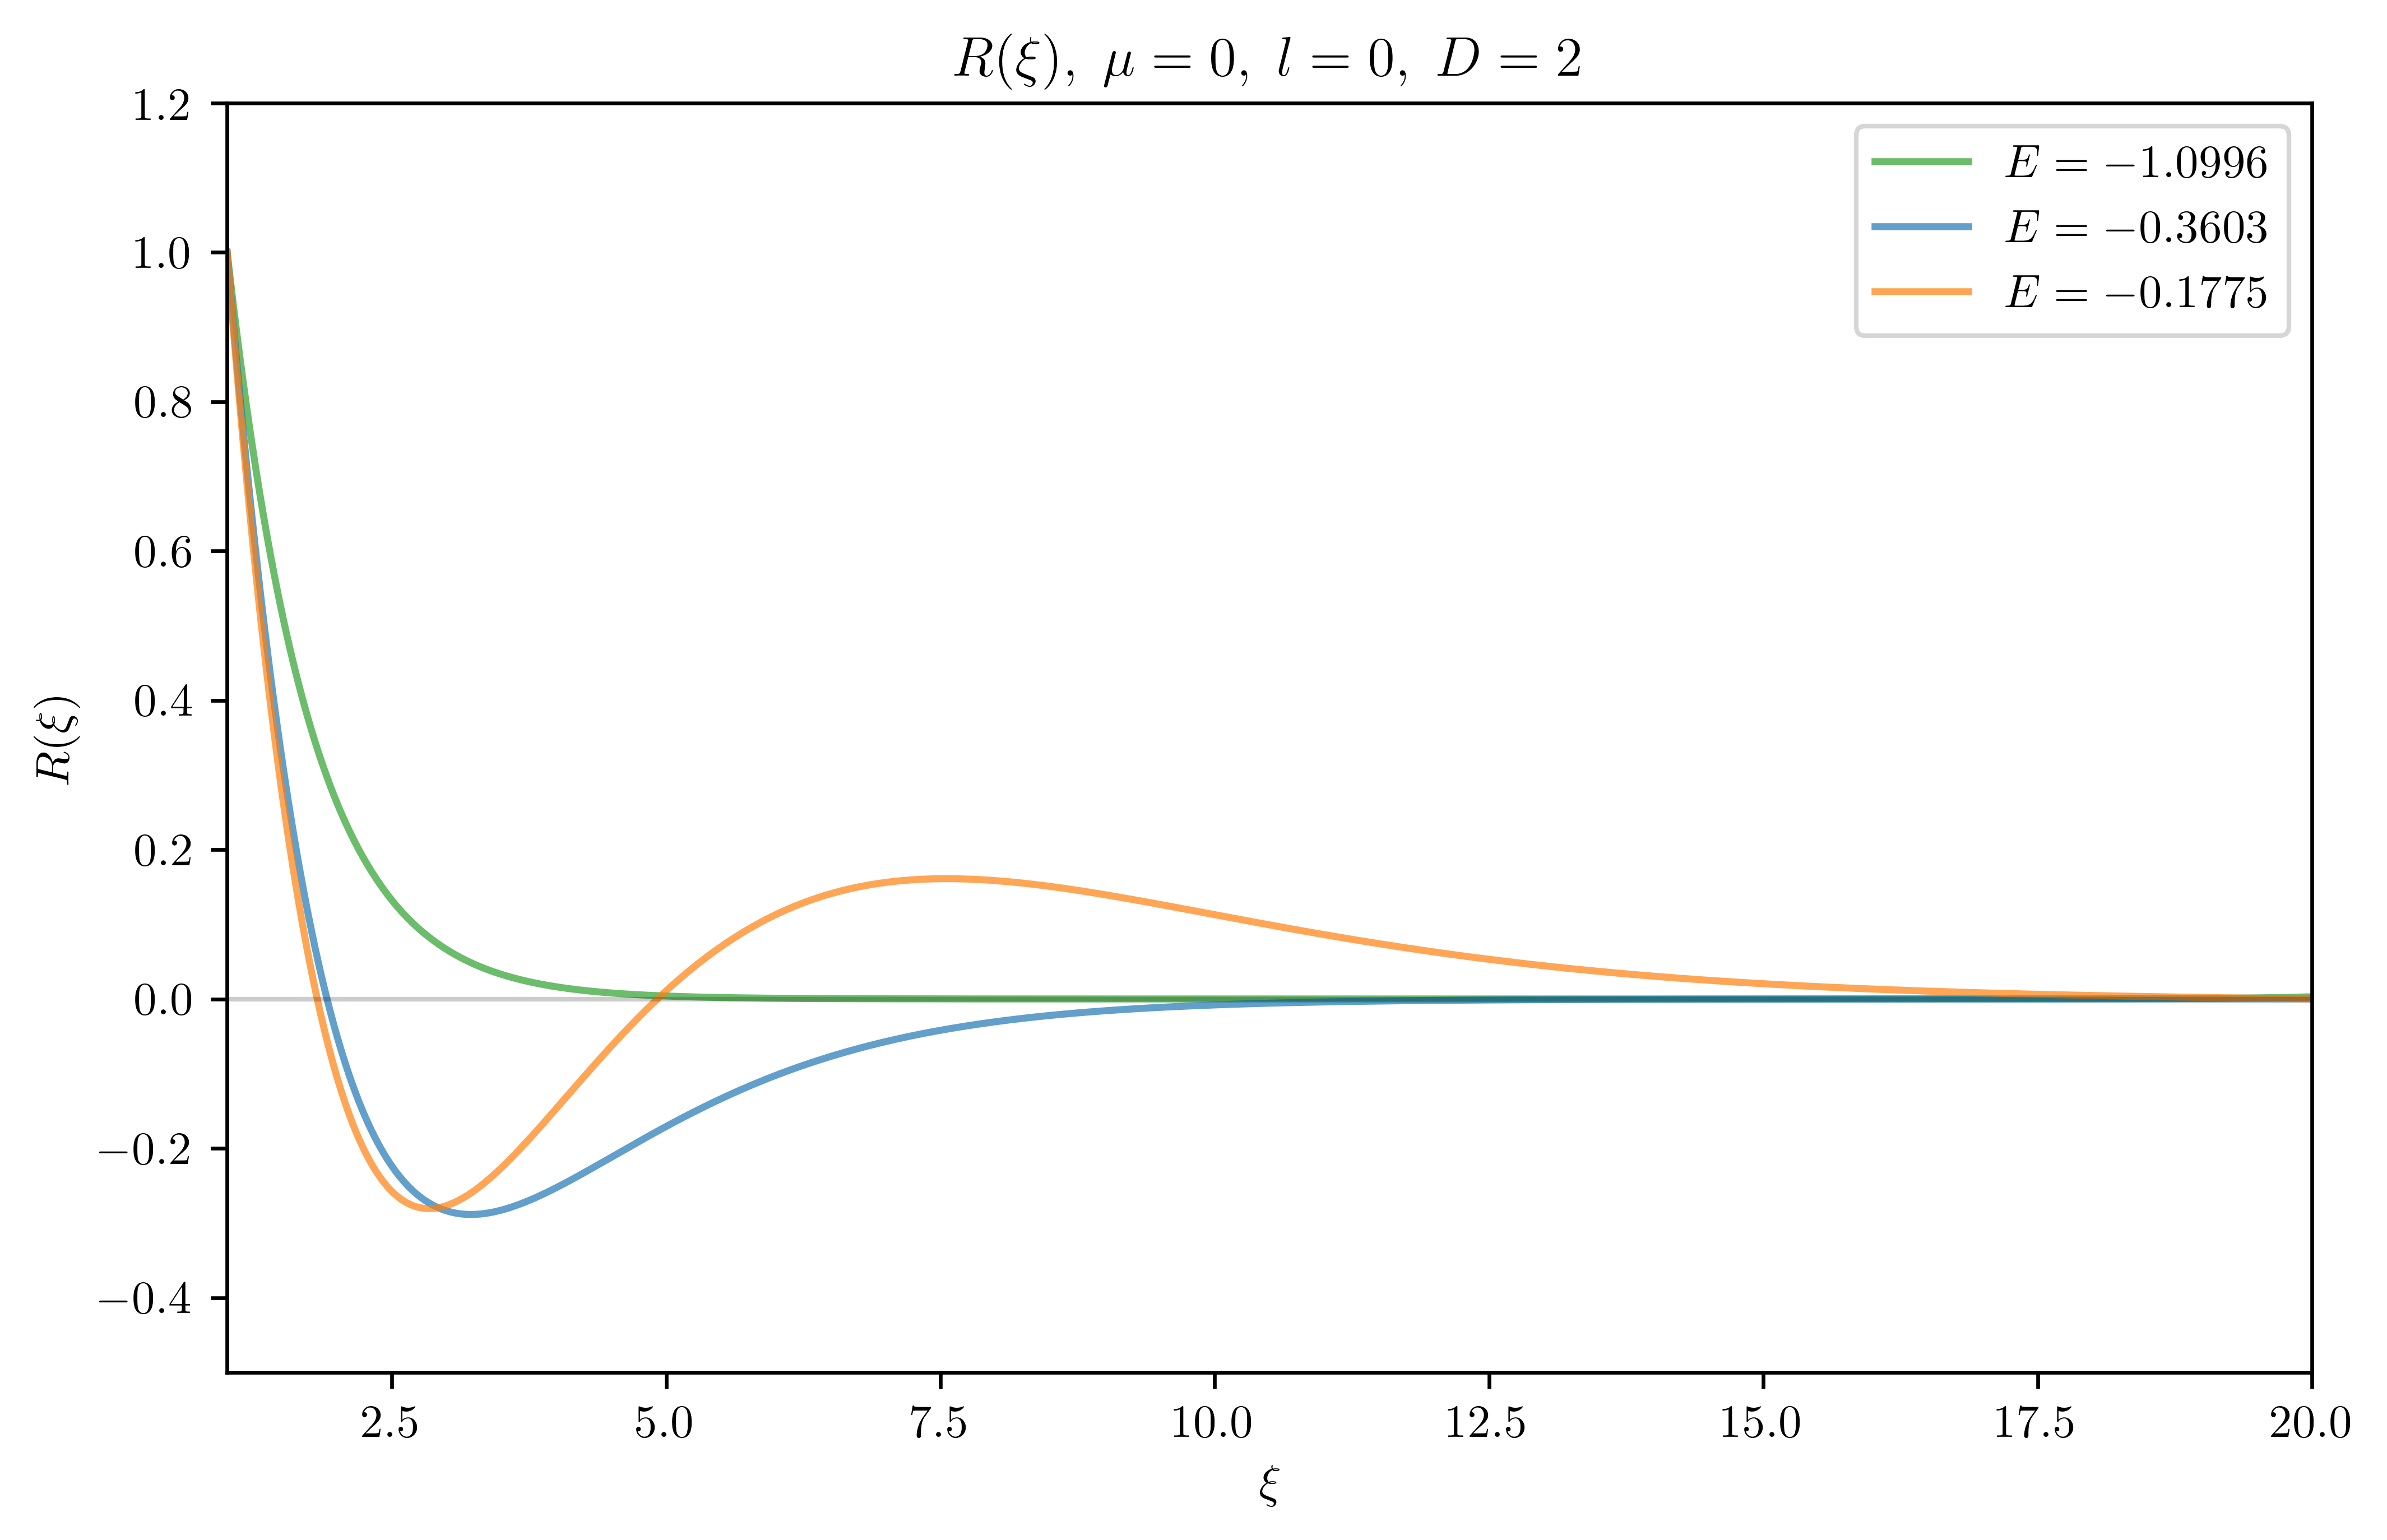

In [2]:
fig, ax = plt.subplots()

# greater cutoff value for higher energy states
cutoff = 20
xi_span = np.linspace(1, cutoff, cutoff*100)

color = ['C2', 'C0', 'C1']

for ind, E_val_guess in enumerate([-1.10, -0.36, -0.17]):
    E_val_final, = fsolve(objective, E_val_guess)

    R_vals = calculate_R(mu, l, E_val_final, lbda, cutoff=cutoff)

    E_val_label = f'$E = {E_val_final:.4f}$'
    ax.plot(xi_span, R_vals, label=E_val_label, color=color[ind], alpha=0.7)
    ax.set_title(fr'$R(\xi), \; \mu = {mu}, \; l = {l}, \; D = {D}$')
    ax.legend()
    ax.set_ylim(-0.5, 1.2)
    ax.set_xlim(1, 20)

ax.axhline(y=0, color='k', alpha=0.2, linewidth=1)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$R(\xi)$');

Notice that # nodes increases by 1 -> n = 1, thus n - 1 radial nodes

misconception: n is not number.

### Before calculating the actual wavefunctions

From D, m, l, n -> psi





















We fixed D, in a way D is a parameter. 

Vary D to vary E, the electronic energy

Figures in textbooks

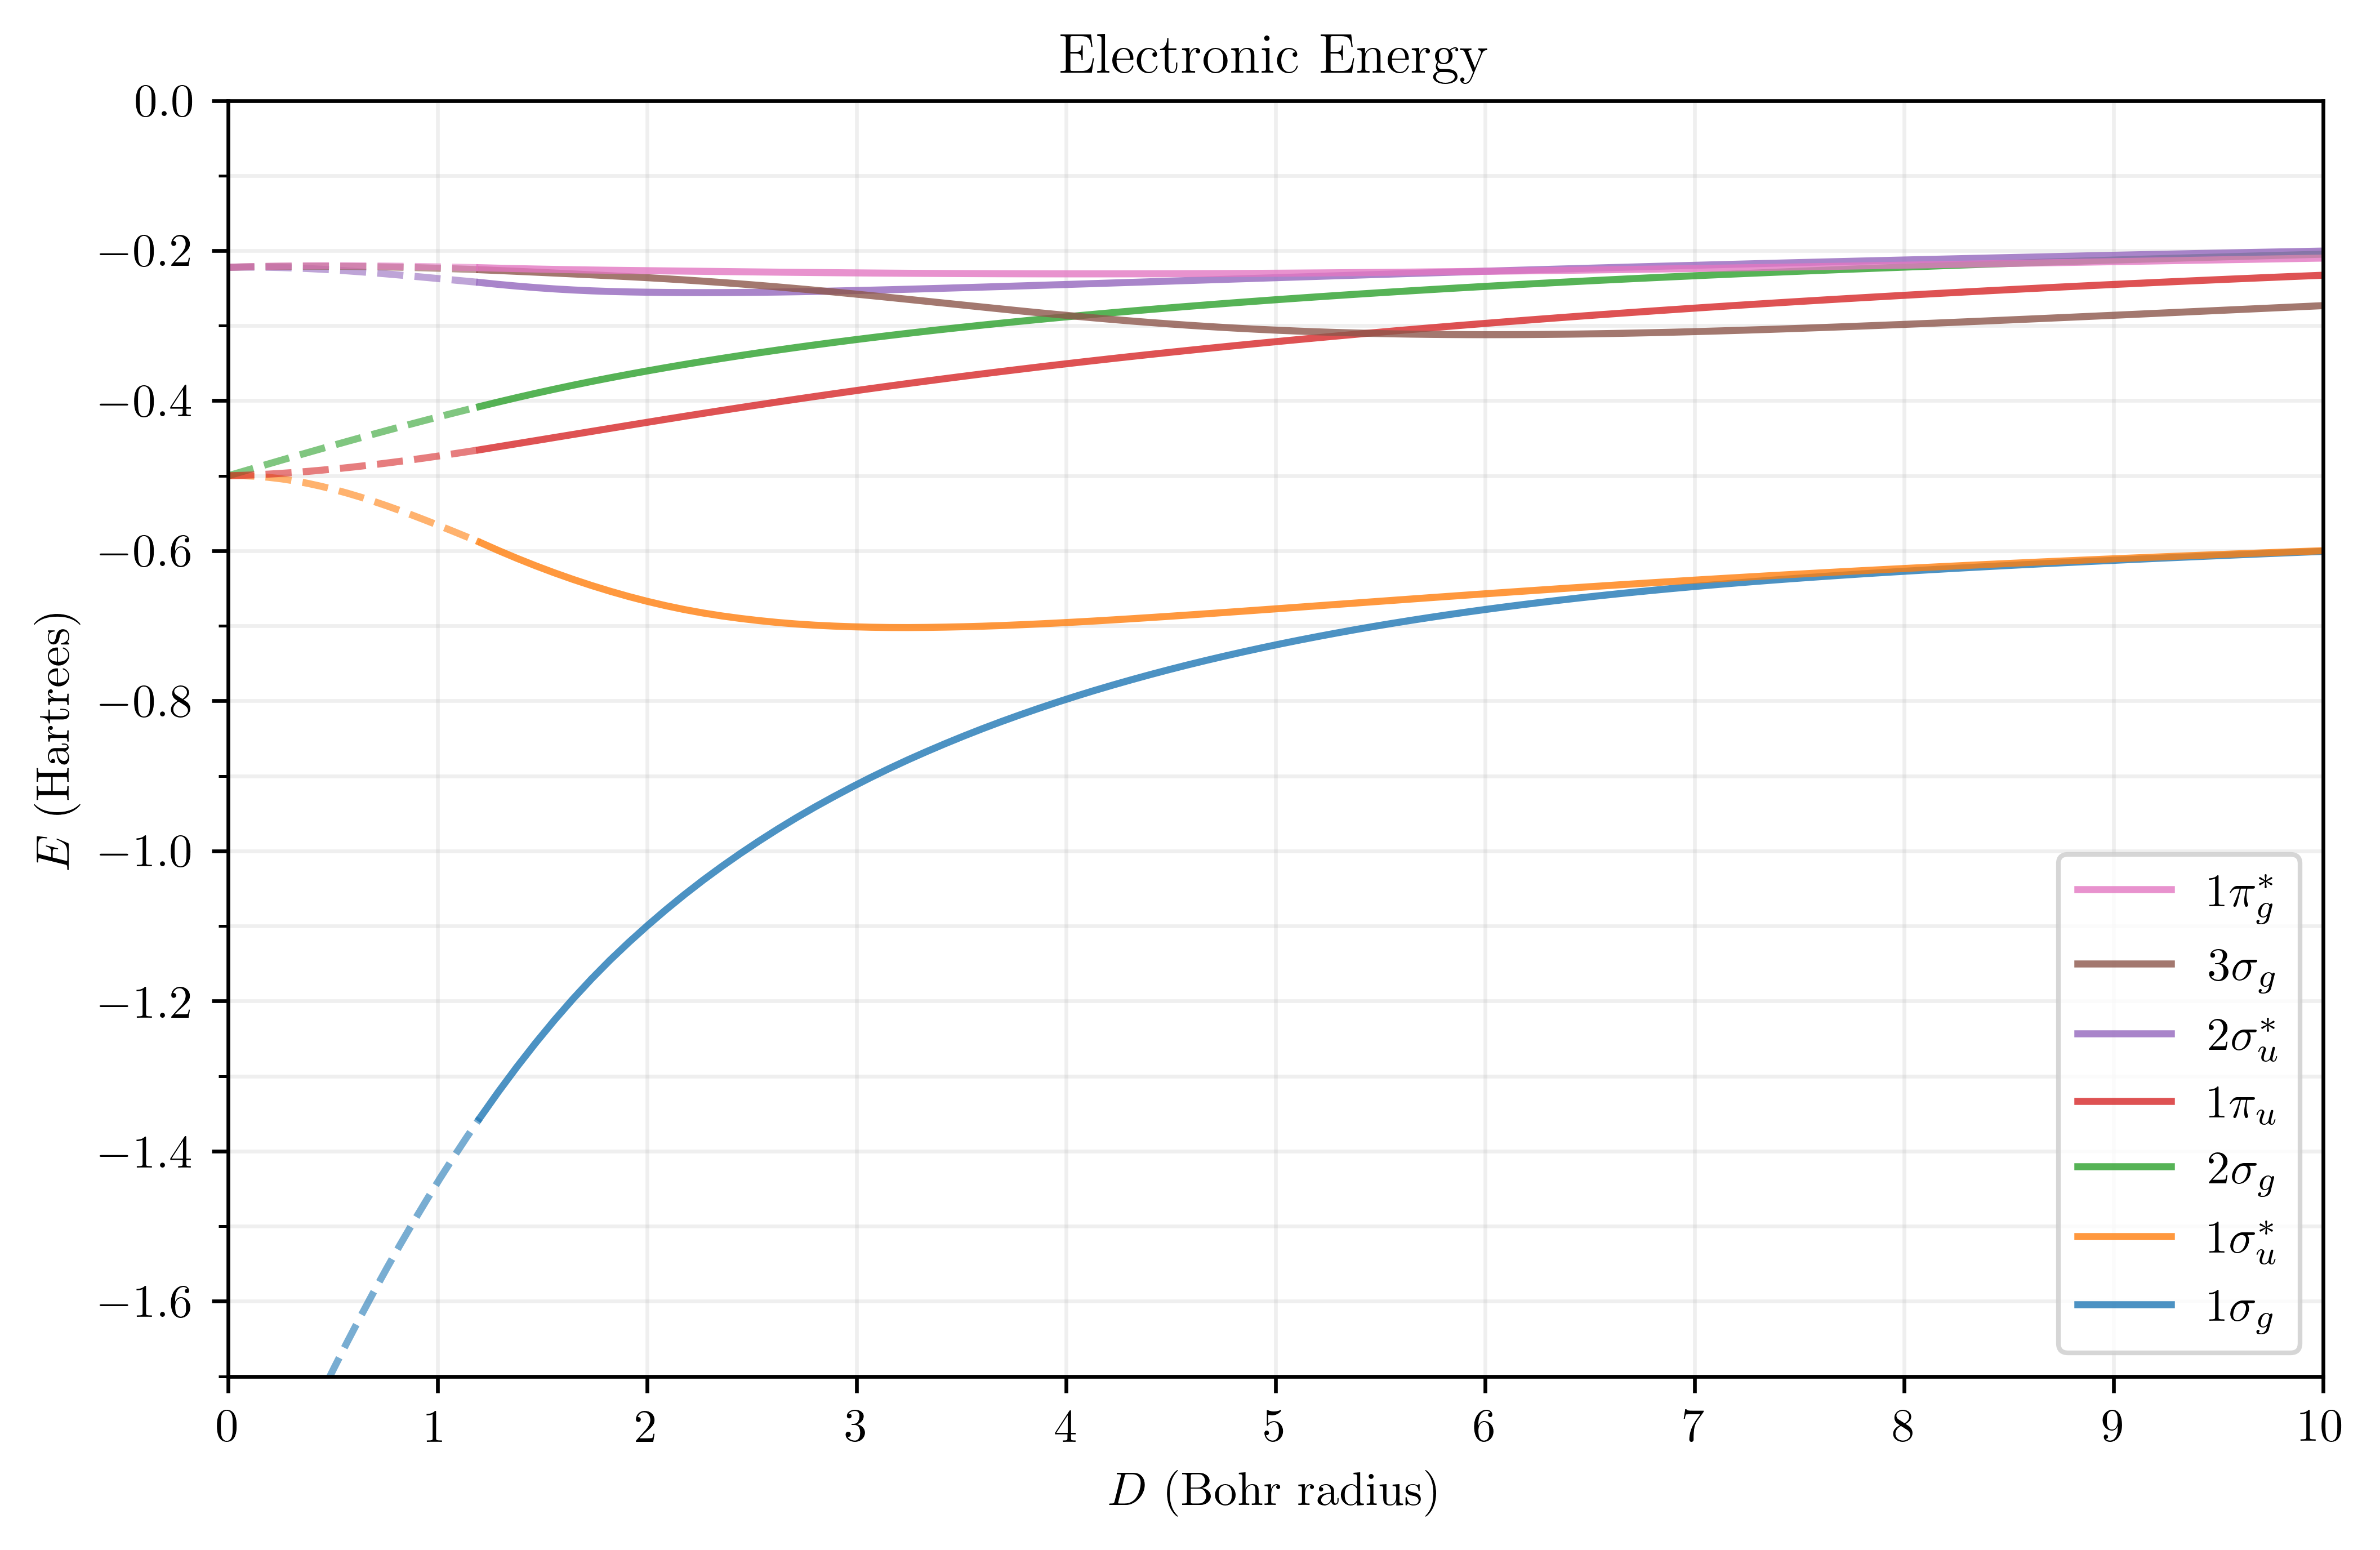

In [3]:
# the ground state requires different energy guesses for different values of D
# as the energy spans over a large range of values for varying values of D

# key: exact MO notation, value: (mu, l, E_guess(value or function of D),)
mos = {
    '1 sigma g': (0, 0, -1.3),
    '1 sigma u *': (0, 1, -0.7),
    '2 sigma g': (0, 0, -0.4),
    '1 pi u': (1, 1, -0.45),
    '2 sigma u *': (0, 1, -0.4),
    '3 sigma g': (0, 2, -0.4),
    '1 pi g *': (1, 2, -0.4),
}

# note: the energy levels of a He+ ion is -2/(n**2)
mo_united_atom = {
    '1 sigma g': -2/1,
    '1 sigma u *': -2/4,
    '2 sigma g': -2/4,
    '1 pi u': -2/4,
    '2 sigma u *': -2/9,
    '3 sigma g': -2/9,
    '1 pi g *': -2/9,
}

mo_latex = {
    '1 sigma g': r"$1 \sigma_{g}$",
    '1 sigma u *': r"$1 \sigma_{u}^{\ast}$",
    '1 pi u': r"$1 \pi_{u}$",
    '2 sigma g' : r"$2 \sigma_{g}$",
    '3 sigma g' : r"$3 \sigma_{g}$",
    '1 pi g *' : r"$1 \pi_{g}^{*}$",
    '2 sigma u *' : r"$2 \sigma_{u}^{*}$",
}

# different spacing as 
D_vals = np.linspace(1.2, 10.0, 20)
D_span = np.linspace(1.2, 10.0, 100)

# using interp1d to connect the data points smoothly
from scipy.interpolate import interp1d
fig, ax = plt.subplots()

for mo, mo_info in mos.items():
    mu, l = mo_info[:2]
    lbda = get_lbda(mu, l)
    
    E_vals = []

    for D in D_vals:
        E_val, = fsolve(objective, mo_info[2])
        E_vals.append(E_val)

    E_vals_interp = interp1d(D_vals, E_vals, kind='quadratic')
    plot_line = ax.plot(D_span, E_vals_interp(D_span), label=mo_latex[mo], alpha=0.8)
    
    # extrapolate to united atom limit using the first 3 values
    
    D_val_extrap = np.concatenate([np.array([0]), D_vals[:3]])
    E_val_extrap = np.concatenate([np.array([mo_united_atom[mo]]), E_vals[:3]])
    
    E_val_extrap_func  = interp1d(D_val_extrap, E_val_extrap, kind='cubic')
    ax.plot(np.linspace(0, 1.2, 20), E_val_extrap_func(np.linspace(0, 1.2, 20)), 
            color=plot_line[0].get_color(), ls='--', alpha=0.6)
    
# reversed legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=4)
ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 10])
ax.set_ylim([-1.7, 0])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.set_title('Electronic Energy');

# TODO: maybe extend the graphs to D = 0 using regression?

E derived from this hamiltonian with no internuclear repulsion term.

Add that in to calculate total energy.

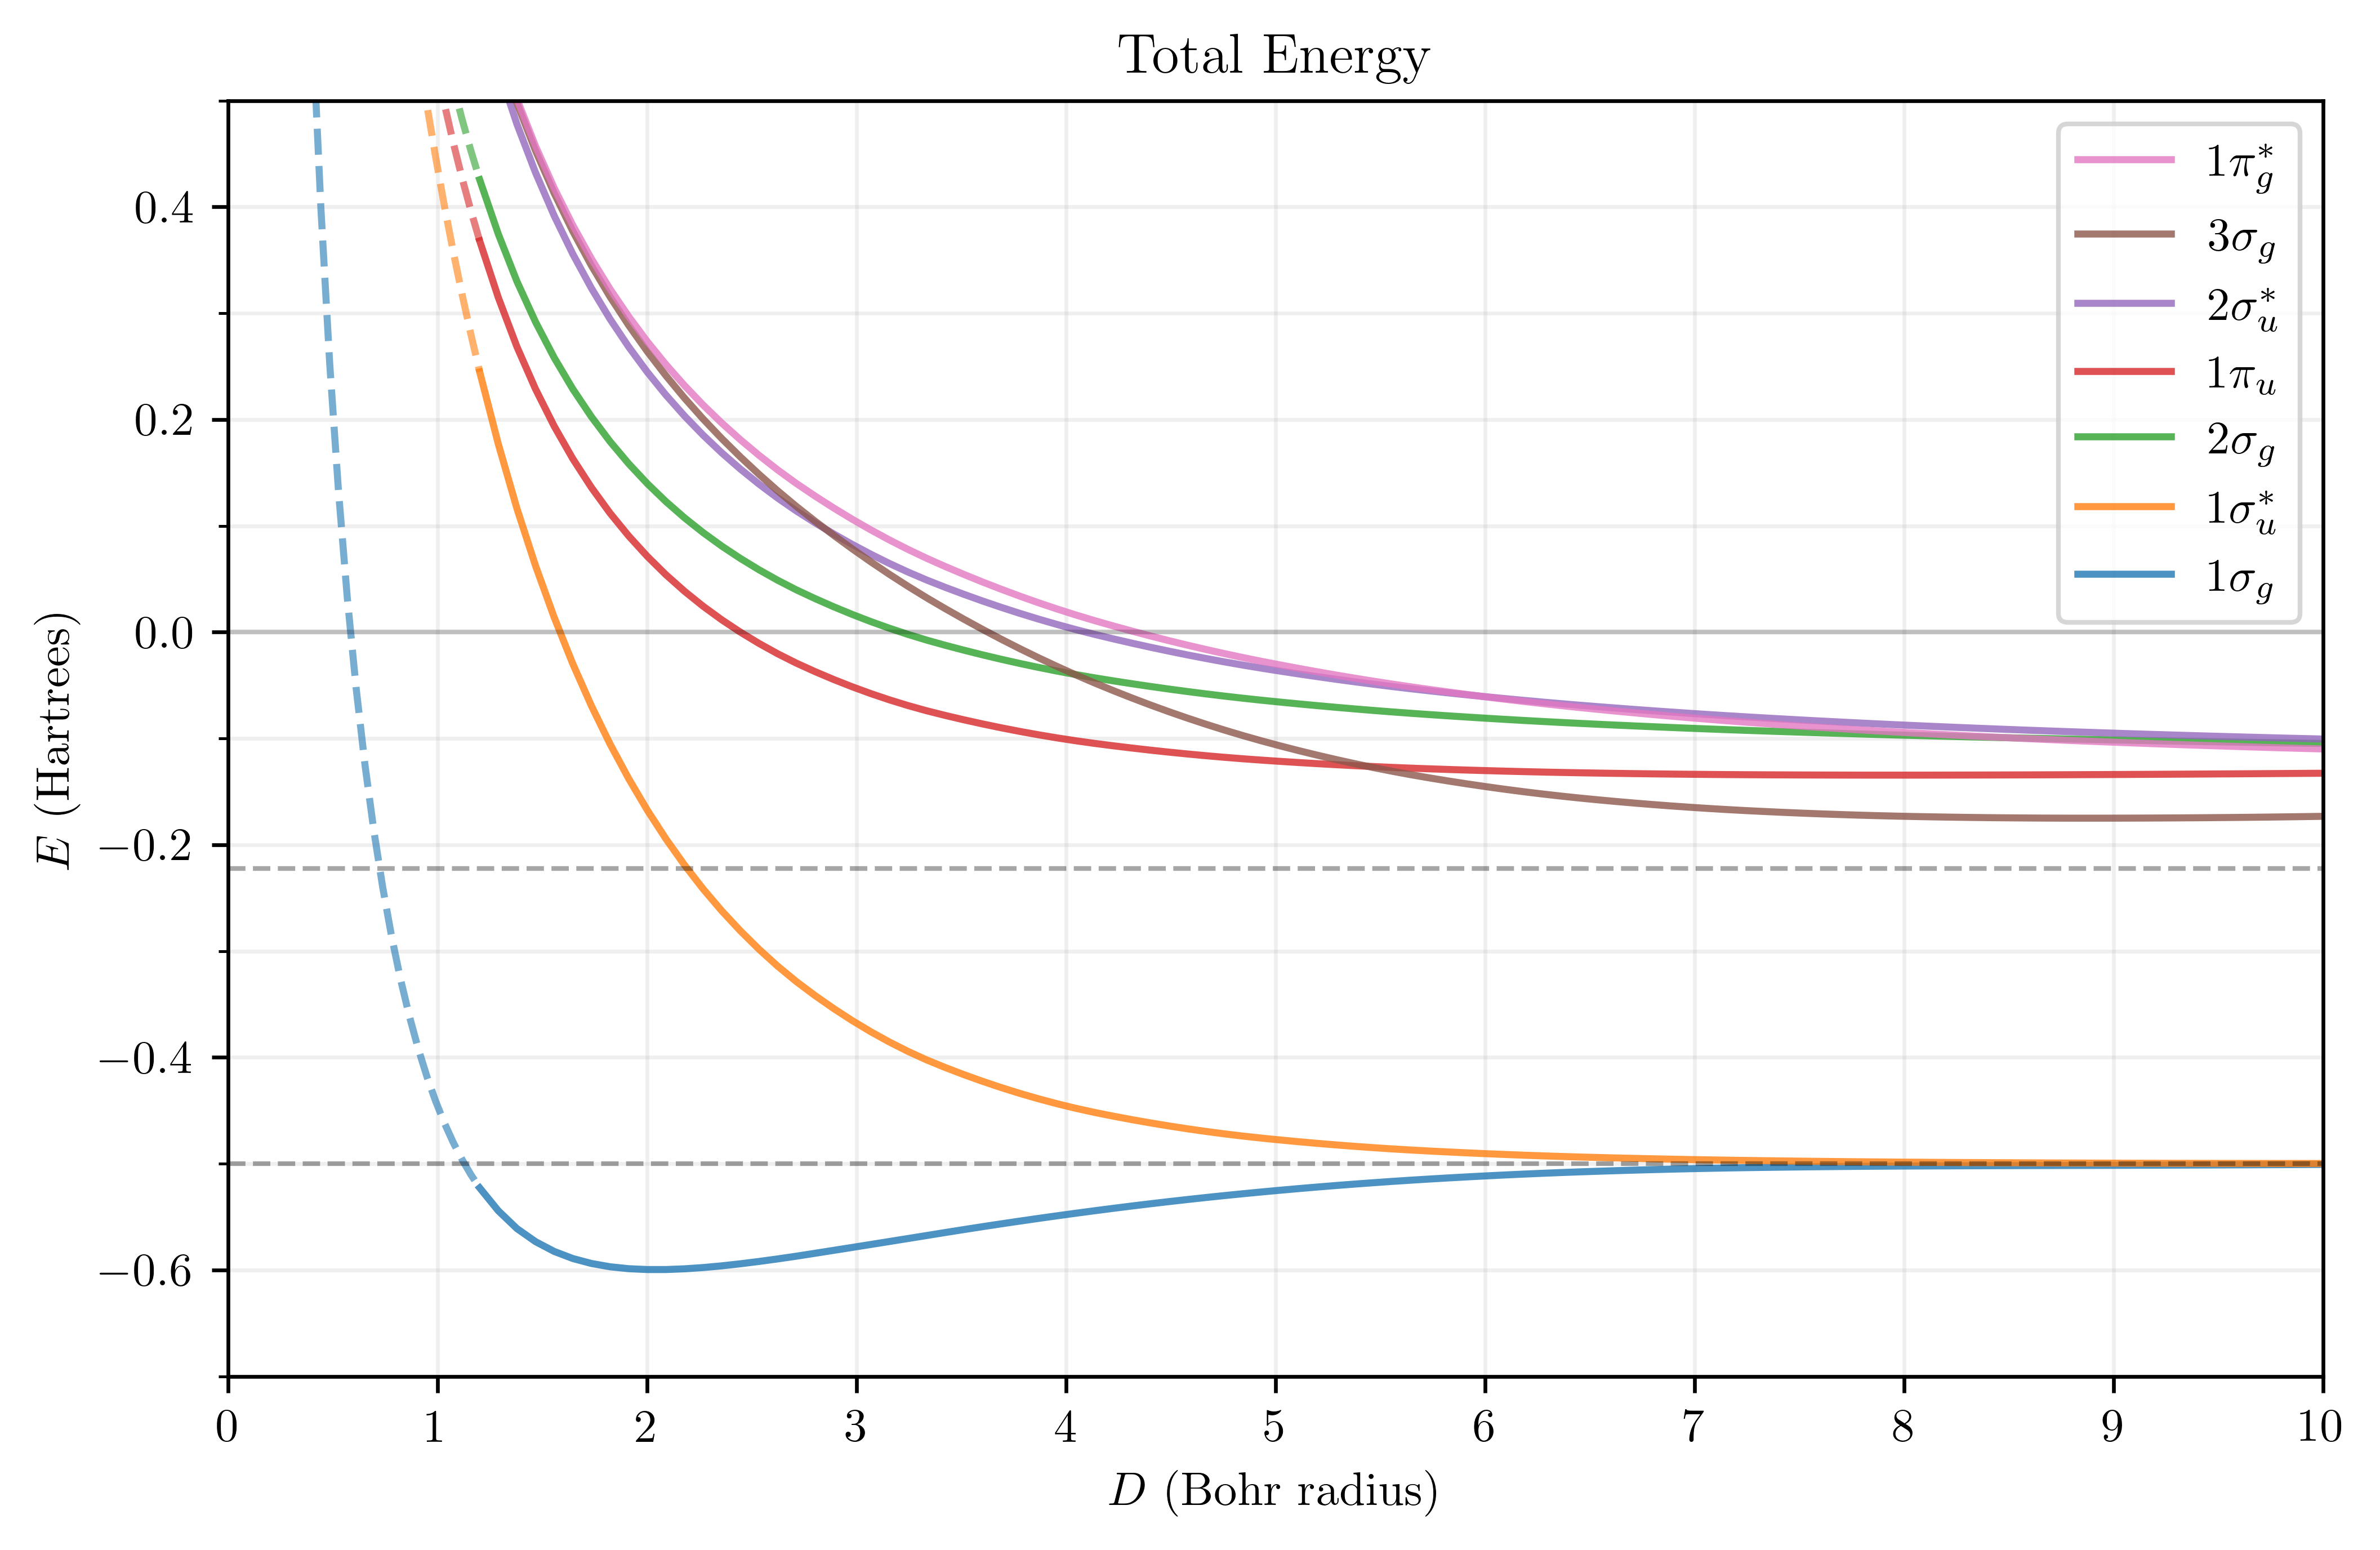

In [4]:
# different spacing as 
D_vals = np.linspace(1.2, 10.0, 20)
D_span = np.linspace(1.2, 10.0, 100)

# curve fitting
from scipy.optimize import curve_fit
fit_func = lambda x, a, b, c, d: (a/x) + b*(x**2) + c*x + d

fig, ax = plt.subplots()

for mo, mo_info in mos.items():
    mu, l = mo_info[:2]
    lbda = get_lbda(mu, l)
    
    E_vals = []
    
    mos_to_extrapolate = list(mos.keys())[:4]
    
    if mo in mos_to_extrapolate:
        D_vals = np.concatenate([np.linspace(1.2, 2.5, 10), np.linspace(3.0, 10.0, 10)])
        D_span = np.linspace(1.2, 10.0, 100)
        
        for D in D_vals:
            E_val, = fsolve(objective,  mo_info[2])
            E_vals.append(E_val + 1/D)
        
        E_vals_interp = interp1d(D_vals, E_vals, kind='quadratic')
        E_vals_plt = E_vals_interp(D_span)
        plot_line = ax.plot(D_span, E_vals_plt, label=mo_latex[mo], alpha=0.8)
        
        # curve fitting using the first 9 interpolated values
        popt, _ = curve_fit(fit_func, D_span[:9], E_vals_plt[:9])
        fit_func_D = np.vectorize(lambda x: fit_func(x, *popt))
        ax.plot(np.linspace(0.4, 1.2, 20), fit_func_D(np.linspace(0.4, 1.2, 20)), 
                color=plot_line[0].get_color(), ls='--', alpha=0.6)
        
    else:
        for D in D_vals:
            E_val, = fsolve(objective, mo_info[2])
            E_vals.append(E_val + 1/D)

        E_vals_interp = interp1d(D_vals, E_vals, kind='quadratic')
        ax.plot(D_span, E_vals_interp(D_span), label=mo_latex[mo], alpha=0.8)

ax.axhline(y=0, color='k', alpha=0.2, linewidth=1) 

# reversed legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=1)

ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 10])
ax.set_ylim([-0.7, 0.5])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.set_title('Total Energy');

### Bonding and Antibonding

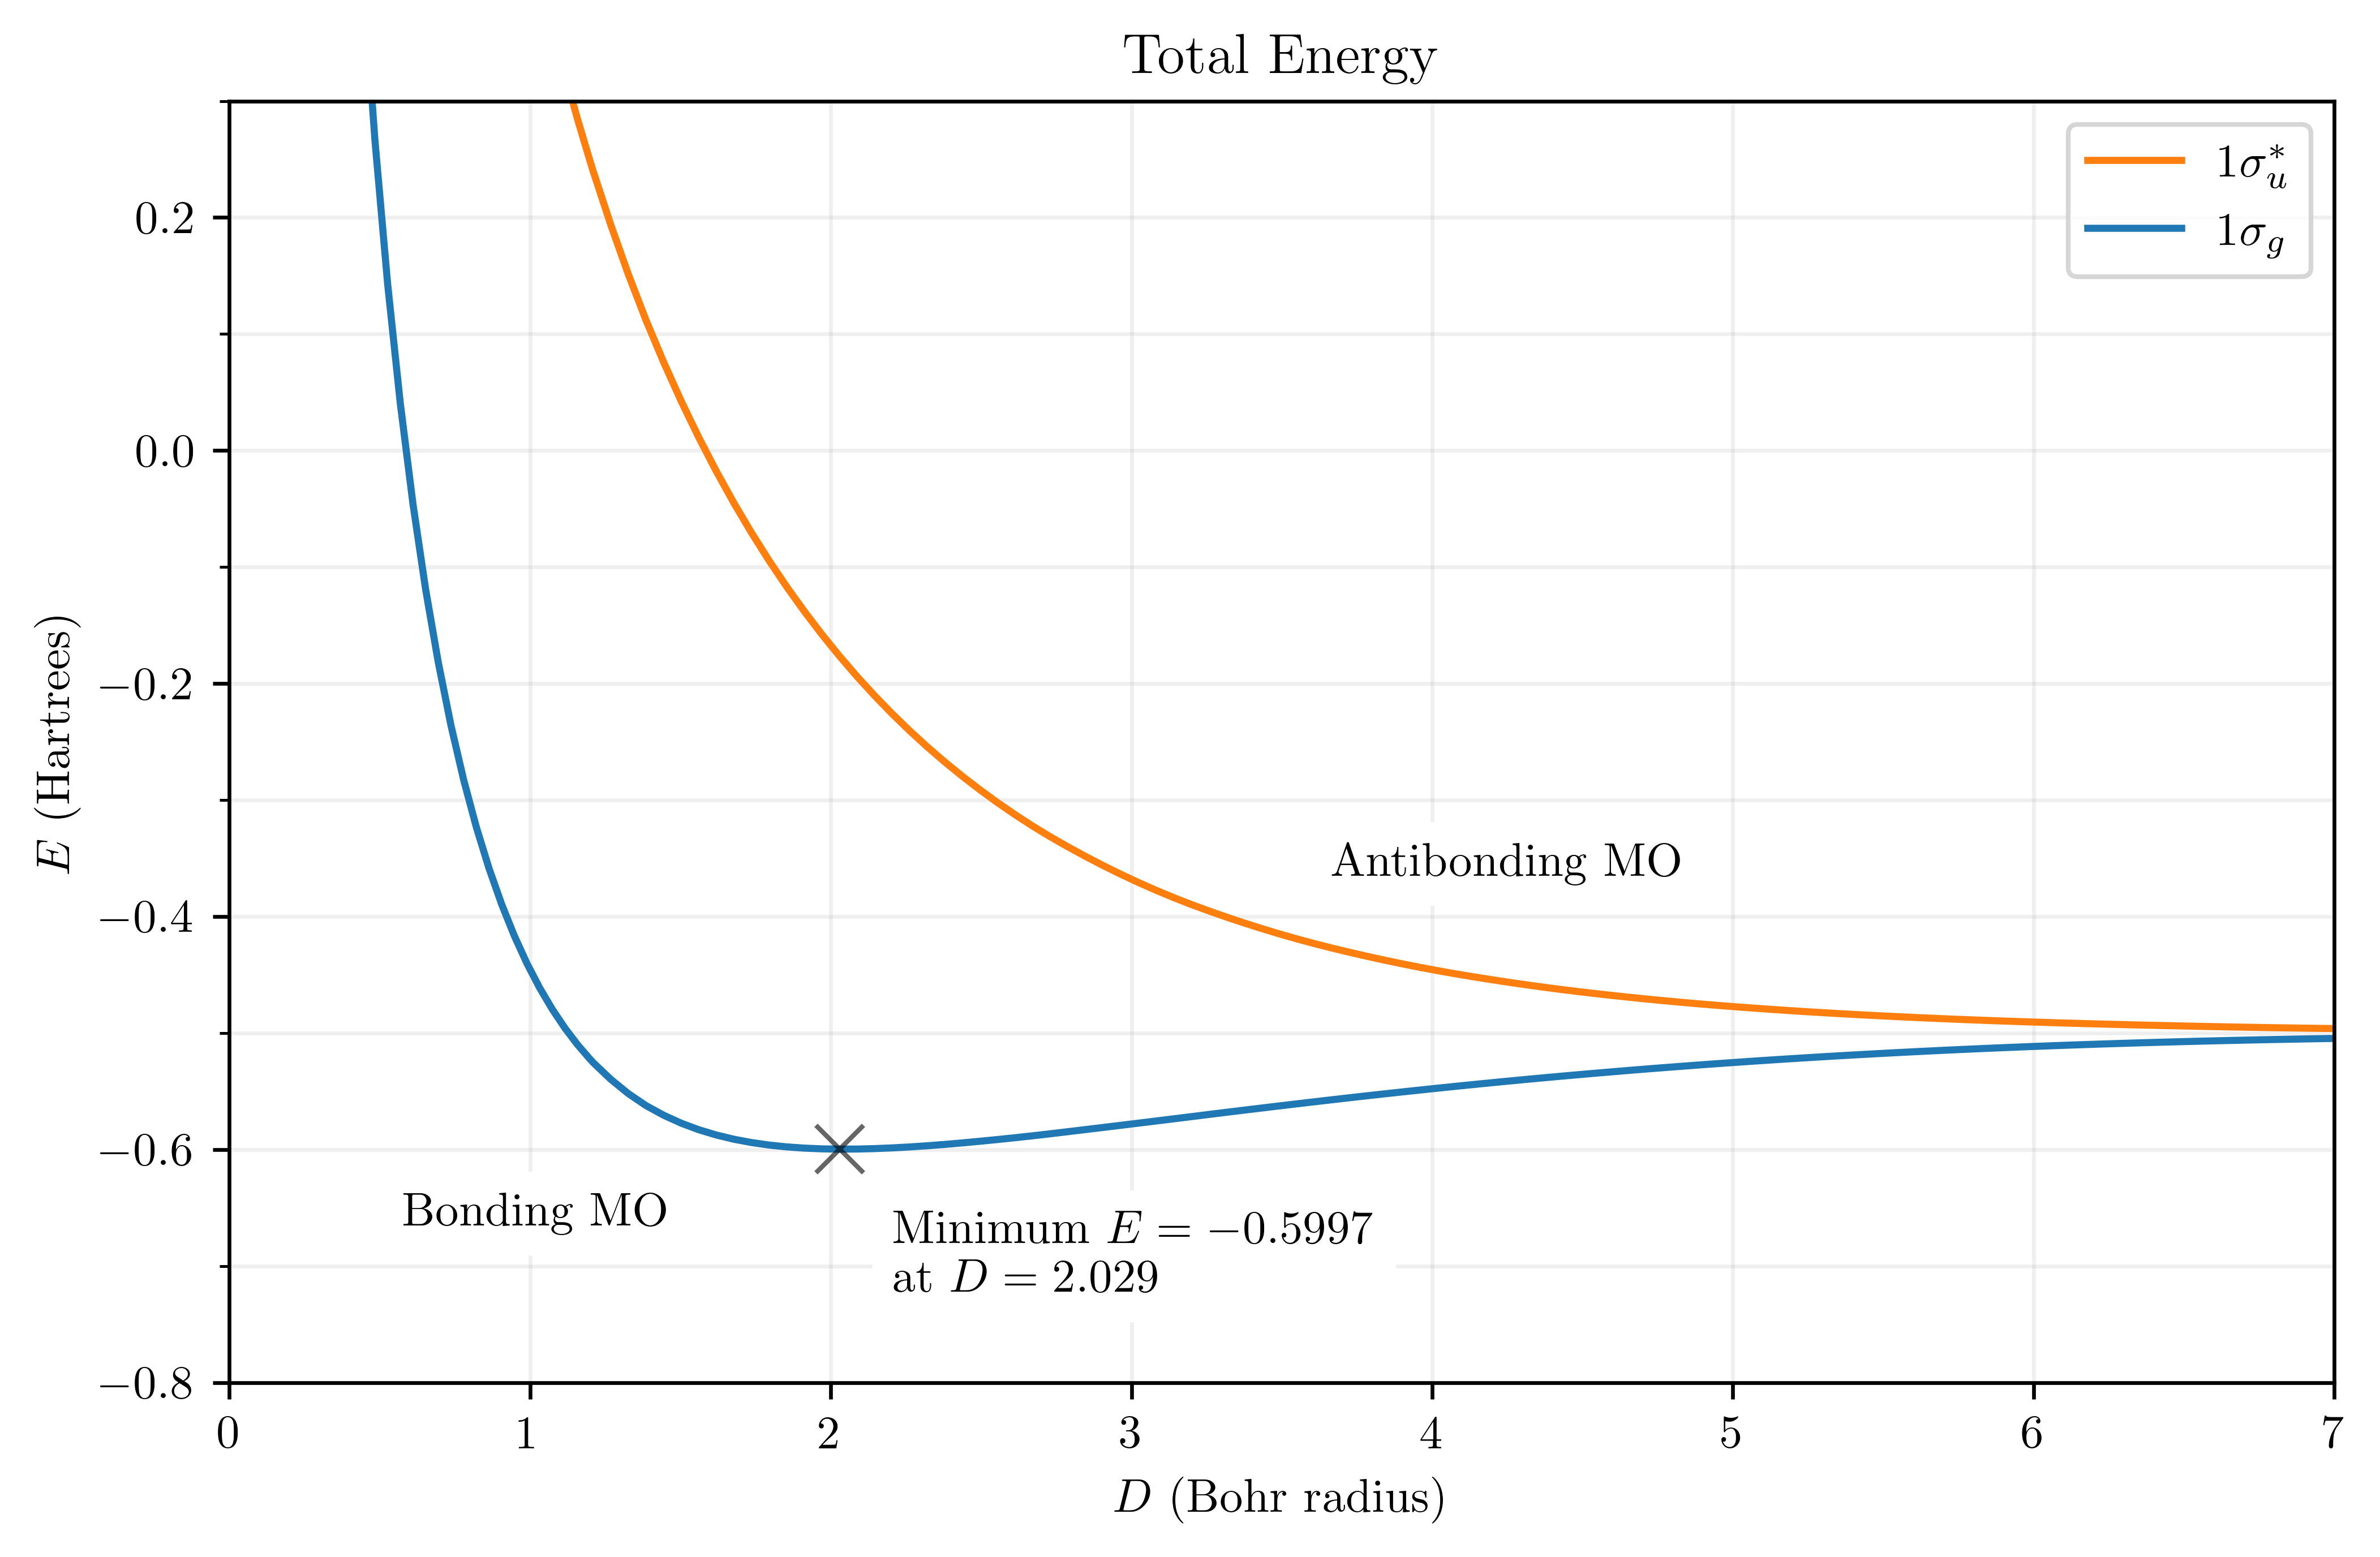

In [5]:
#E_1s = -1.0

# reduce cutoff for more performance
cutoff = 10



fig, ax = plt.subplots()

# for use in finding the minimum and later examples
MO_list = []
MO_notation = [r'$1\sigma_g$', r'$1\sigma_u^*$']

for mu, l, lbda, E_val_guess in ((0, 0, get_lbda(0, 0), -1.3), 
                                 (0, 1, get_lbda(0, 1), -0.7)):
    
    
    # different spacing as 
    D_vals = np.concatenate([np.linspace(1.2, 2.5, 10), np.linspace(3.0, 7.0, 10)])
    D_span = np.linspace(1.21, 7.0, 100)
    
    E_vals = []
    
    for D in D_vals:
        E_val, = fsolve(objective,  E_val_guess)
        E_vals.append(E_val + 1/D)

    E_vals_interp = interp1d(D_vals, E_vals, kind='quadratic')
    E_vals_plt = E_vals_interp(D_span)

    # curve fitting using the first 9 interpolated values
    popt, _ = curve_fit(fit_func, D_span[:9], E_vals_plt[:9])
    fit_func_D = np.vectorize(lambda x: fit_func(x, *popt))
    
    D_span = np.concatenate([np.linspace(0.4, 1.2, 20), D_span])
    E_vals_plt = np.concatenate([fit_func_D(np.linspace(0.4, 1.2, 20)), E_vals_plt])
    
    MO_list.append((D_span, E_vals_plt))
    ax.plot(D_span, E_vals_plt, label=MO_notation[l])

# find the minimum for the ground state
min_ind = np.argmin(MO_list[0][1])
min_E, min_E_D = MO_list[0][1][min_ind], MO_list[0][0][min_ind]

ax.plot([min_E_D], [min_E], marker='x', markersize=10, color='k', alpha=0.6)

t = ax.text(min_E_D + 0.18, min_E - 0.092, f'Minimum $E = {min_E:.4f}$\n at $D = {min_E_D:.3f}$',
            va='center', ha='left')
t.set_bbox(dict(facecolor='w', edgecolor='w'))
t = ax.text(1.02, -0.655, 'Bonding MO', va='center', ha='center')
t.set_bbox(dict(facecolor='w', edgecolor='w'))
t = ax.text(4.25, -0.355, 'Antibonding MO', va='center', ha='center')
t.set_bbox(dict(facecolor='w', edgecolor='w'))

ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 7])
ax.set_ylim([-0.8, 0.3])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

# reversed legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=1)

ax.set_title('Total Energy');

### Comparison with LCAO

Compare with LCAO

$$S(D) = e^{-D}\left ( 1 + D + \frac{D^2}{3} \right )$$

$$J = e^{-2D}\left ( 1+\frac{1}{D} \right ) \text{ and } $$

$$K = \frac{S}{D} - e^{-D}\left ( 1 + D \right )$$

$$\Delta E_+ = E_+ - E_{1s} = \frac{J + K}{1 + S}$$

$$\Delta E_- = E_- - E_{1s} = \frac{J - K}{1 - S}$$

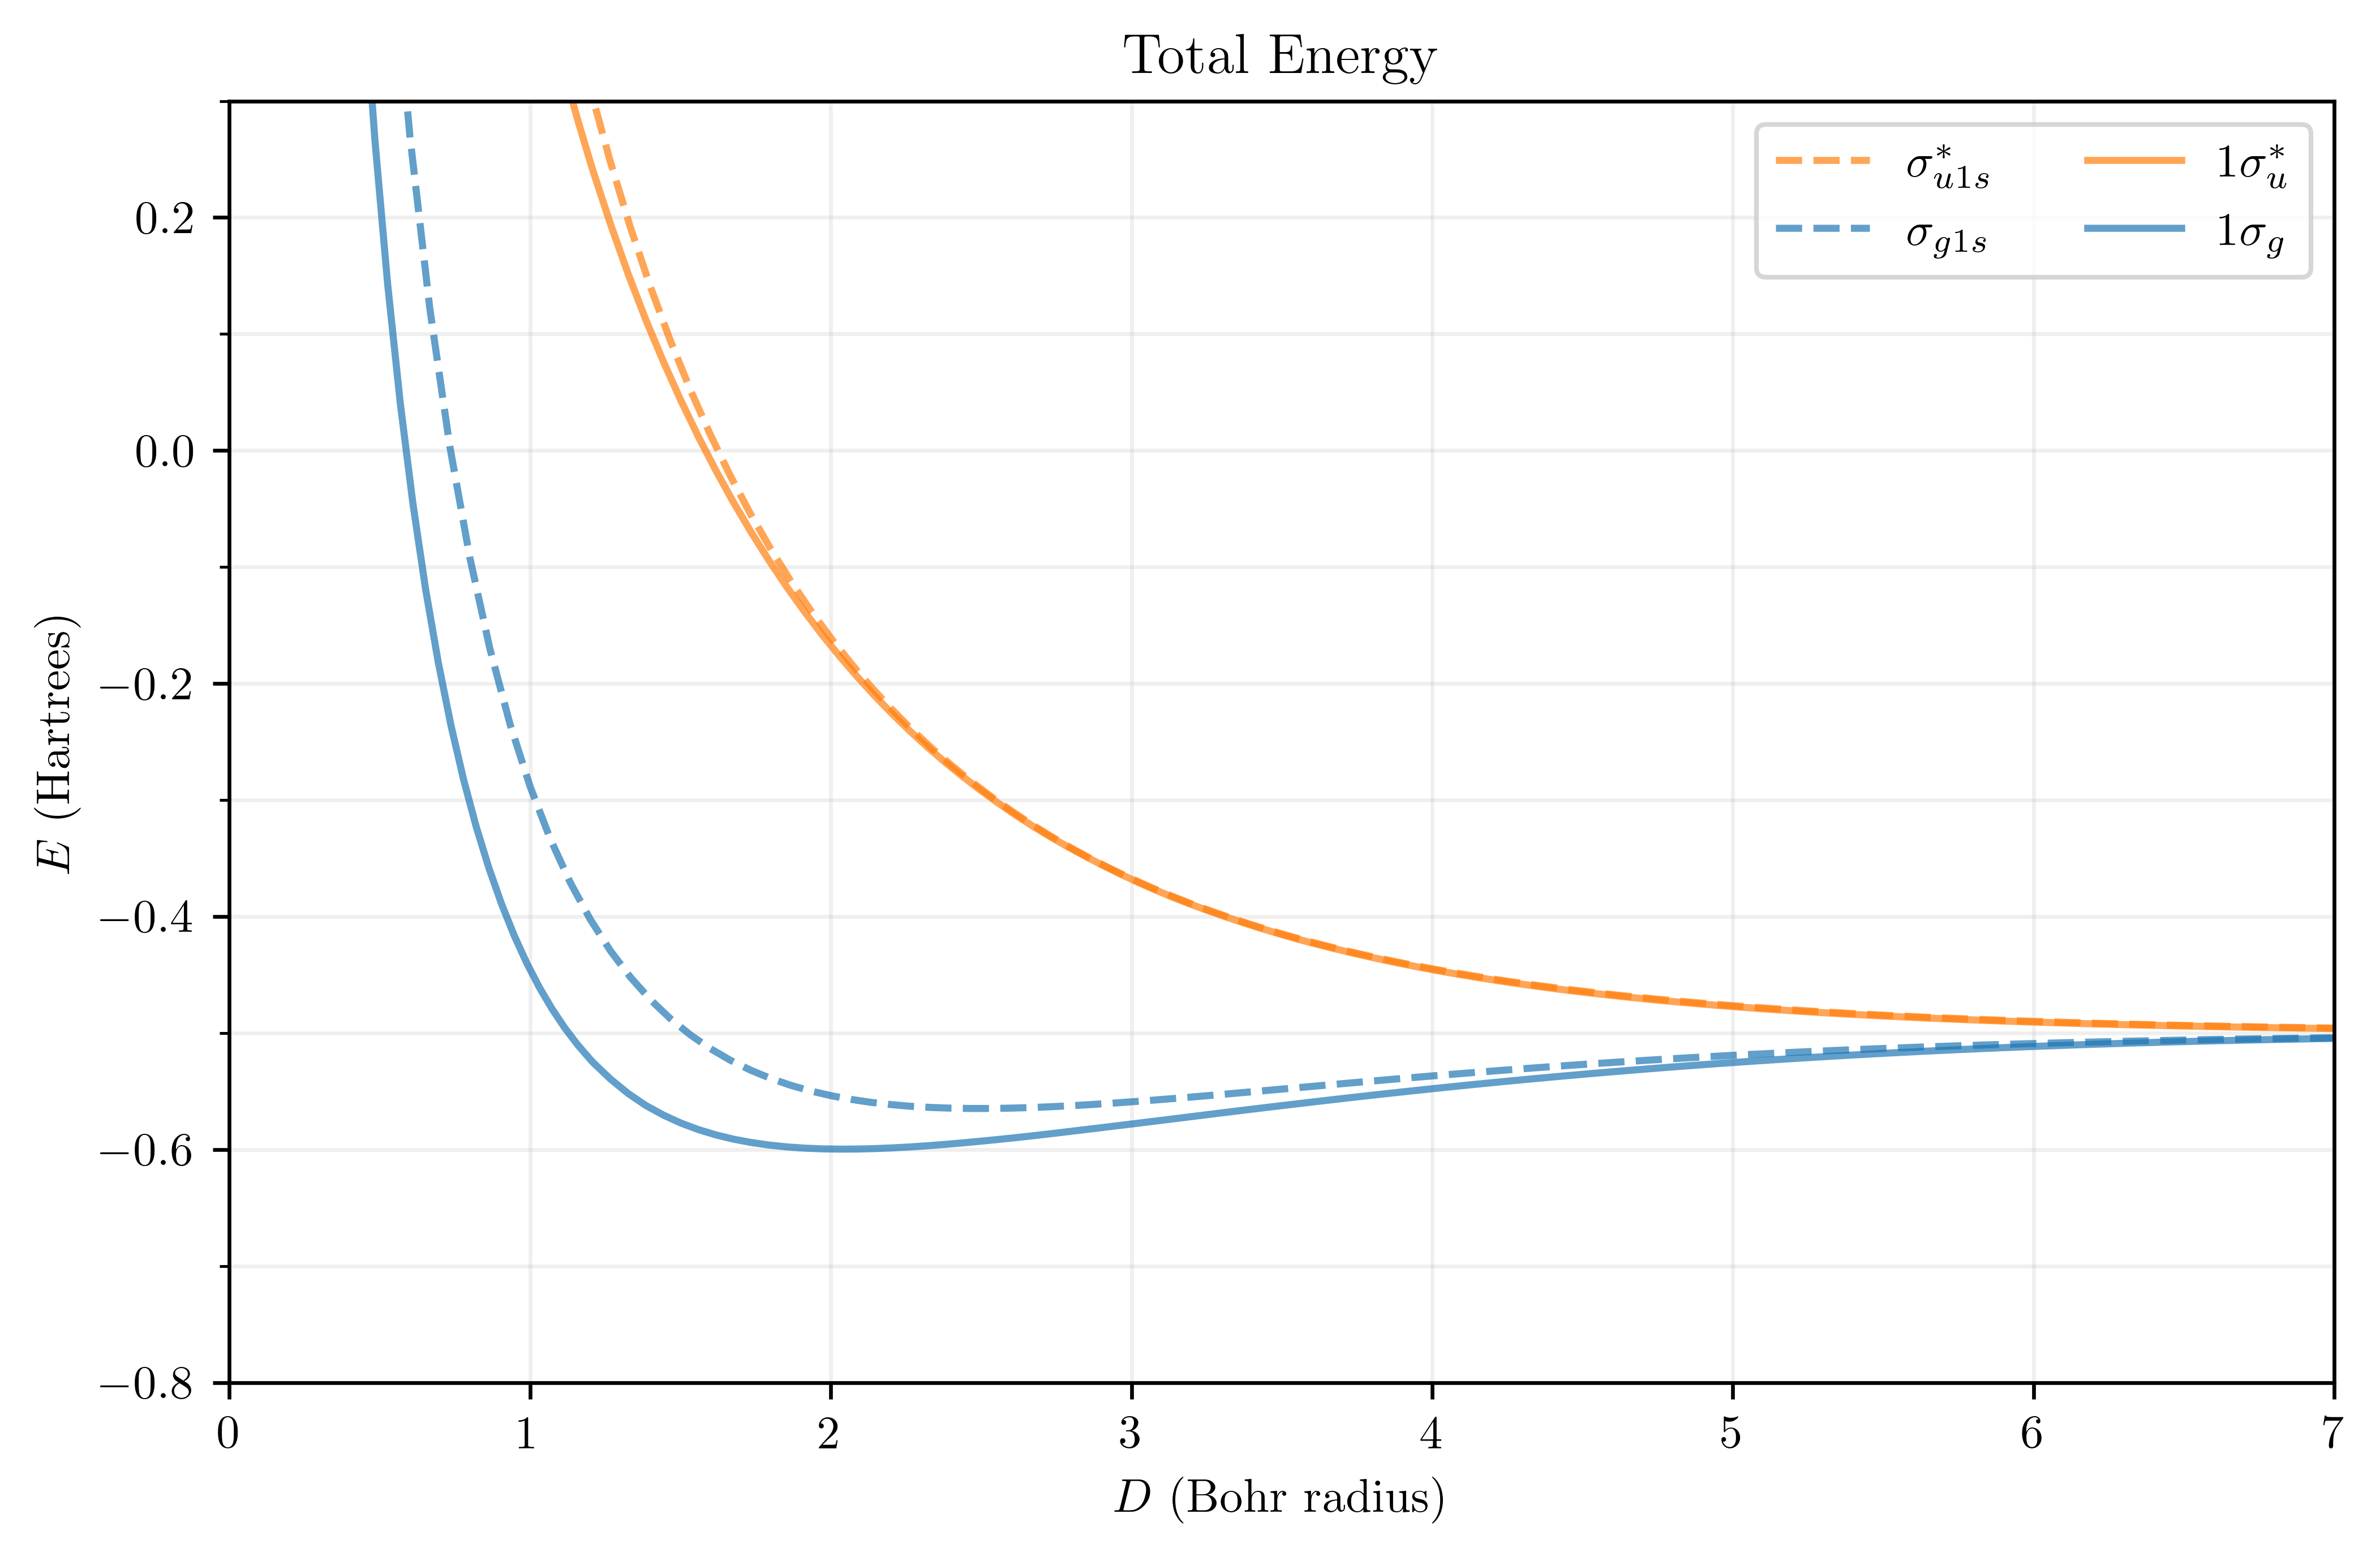

In [6]:
S = lambda D: np.exp(-D) * (1+D+((D**2)/3))
J = lambda D: np.exp(-2*D) * (1+(1/D))
K = lambda D: (S(D)/D) - np.exp(-D) * (1+D)

E_plus = lambda D: (J(D)+K(D))/(1+S(D))
E_minus = lambda D: (J(D)-K(D))/(1-S(D))

fig, ax = plt.subplots()
colors = ['C0', 'C1']
LCAO_notation = [r'$\sigma_{g1s}$', r'$\sigma_{u1s}^*$']

# directly from the previous example
for ind, plt_data in enumerate(MO_list):
    plot_line = ax.plot(plt_data[0], plt_data[1], alpha = 0.7, 
                        color=colors[ind], label=MO_notation[ind])
    
for mu, l, lbda, E_val_guess in ((0, 0, get_lbda(0, 0), -1.3), 
                                 (0, 1, get_lbda(0, 1), -0.7)):
    # plot results from LCAO
        delta_E = E_plus if l == 0 else E_minus
        LCAO_E = np.vectorize(lambda D: delta_E(D) - 0.5)

        ax.plot(np.linspace(0.4, 7.0, 100), LCAO_E(np.linspace(0.4, 7.0, 100)), 
                ls='--', color=colors[l], alpha = 0.7, label=LCAO_notation[l])

ax.grid(which='both', alpha=0.2)
ax.set_xlim([0, 7])
ax.set_ylim([-0.8, 0.3])
ax.set_xlabel('$D$ (Bohr radius)')
ax.set_ylabel('$E$ (Hartrees)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

# reversed legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc=1, ncol=2)

ax.set_title('Total Energy');